# Clustering (KMeans, DBSCAN, OPTICS, Spectral Clustering, Hierarchical Clustering)

**Исполнители (ФИО):** Буканов Иван

---



Здравствуйте, на этом семинаре вы познакомитесь с задачей Кластеризации, методами К-средних, DBSCAN, его модификацией OPTICS, Спектральной кластеризацией, Иерархической кластеризацией, а так же с различными метриками качества кластеризации

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering


[Метрики качества кластеризации](https://www.geeksforgeeks.org/machine-learning/clustering-metrics/)

[Сравнение методов кластеризаций](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html)

[Иерархическая кластеризация](https://www.geeksforgeeks.org/machine-learning/hierarchical-clustering-with-scikit-learn/)

## Задача 1


### Введение в Кластеризацию

Для начала познакомимся с методом К-средних. Этот метод основан на предположении, что кластеры имеют сферическую структуру (куча). Создайте две непересекающиеся кучи и примените к ним метод [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), визуализируйте результаты


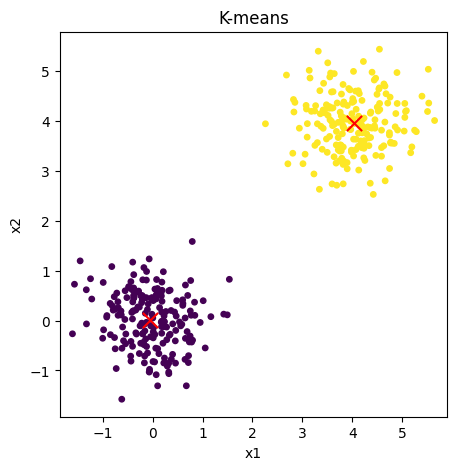

In [5]:
# Две непересекающиеся кучи
n = 200
blob1 = np.array([0.0, 0.0]) + 0.55 * np.random.randn(n, 2)
blob2 = np.array([4.0, 4.0]) + 0.55 * np.random.randn(n, 2)
X = np.vstack([blob1, blob2])

# K-means
kmeans = KMeans(n_clusters=2, n_init=10)
labels = kmeans.fit_predict(X)
centers = kmeans.cluster_centers_

plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], s=15, c=labels)
plt.scatter(centers[:, 0], centers[:, 1], s=120, marker="x", color="red")
plt.title("K-means")
plt.xlabel("x1"); plt.ylabel("x2"); plt.axis("equal")
plt.show()

Однако, с данными, которые устроены более сложным образом, например, ленточные кластеры, KMeans работает хуже.

Создайте две смещенные параболы вида $X_{1}\sim R[-1.4, 0.6], X_{2}\sim R[-0.6, 1.4], Y_{1}\sim X_{1}^{2} - 0.6 + Z_{1}, Y_{1}\sim X_{2}^{2} + 0.6 + Z_{2}$, где $Z_{i}\sim \mathcal{N}(0, 0.4)$ и примените этот метод к ним, визуализируйте результат

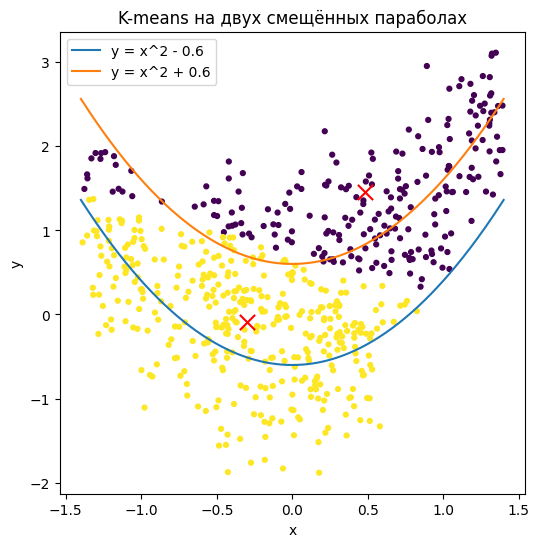

In [23]:
# Параметры и данные
n = 300
x1 = np.random.uniform(-1.4, 0.6, n)
x2 = np.random.uniform(-0.6, 1.4, n)
z1 = np.random.normal(0.0, np.sqrt(0.4), n)
z2 = np.random.normal(0.0, np.sqrt(0.4), n)

y1 = x1**2 - 0.6 + z1
y2 = x2**2 + 0.6 + z2

X = np.column_stack([np.r_[x1, x2], np.r_[y1, y2]])

# K-means
kmeans = KMeans(n_clusters=2, n_init=20)
labels = kmeans.fit_predict(X)
centers = kmeans.cluster_centers_

# Визуализация
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], s=12, c=labels)
plt.scatter(centers[:, 0], centers[:, 1], s=120, marker="x", color="red")
t = np.linspace(-1.4, 1.4, 400)
plt.plot(t, t**2 - 0.6, label="y = x^2 - 0.6")
plt.plot(t, t**2 + 0.6, label="y = x^2 + 0.6")
plt.title("K-means на двух смещённых параболах")
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.show()

Метод [Spectral Clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html) позволяет работать со сложными структурами за счёт преобразования данным с помощью нелинейного ядра. Теперь примените этот метод к параболам, визуализируйте результаты

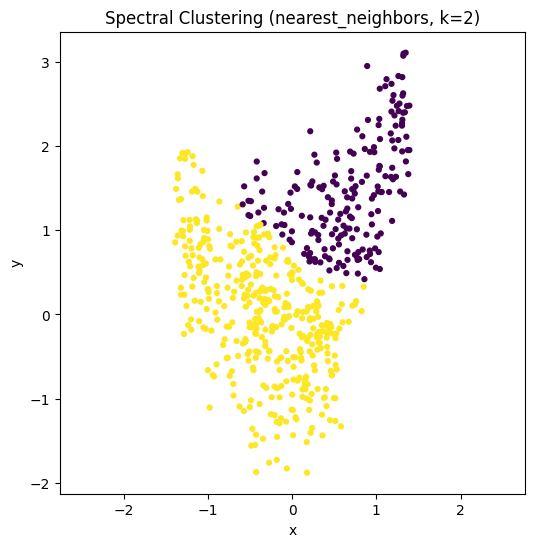

In [25]:
spec = SpectralClustering(
    n_clusters=2,
    affinity="nearest_neighbors",
    n_neighbors=15,
    assign_labels="kmeans"  # разбиение в спектральном пространстве
)
labels_sc = spec.fit_predict(X)

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], s=12, c=labels_sc)
plt.title("Spectral Clustering (nearest_neighbors, k=2)")
plt.xlabel("x"); plt.ylabel("y"); plt.axis("equal")
plt.show()

**Вопрос:** Почему данные кластеризовались именно так в этих методах? Обоснуйте свой ответ

Кластеризация получилась практически одинаковой, небольшие отличия есть лишь на левой границе разделений, где Spectral Clustering "поймало" ветвь нижней параболы.
Геометрия данных: для одного и того же x средние отличаются на 1.2 => $Y_2-Y_1=1.2+(Z_2-Z_1)\sim \mathcal N(1.2,\,0.8)$.
Вероятность перепутать ветви: $P(Y_2<Y_1)\approx \Phi(-1.2/\sqrt{0.8})\approx 0.089$ => перекрытие около 9%, компоненты уже неплохо разделены по построению.

Теперь возьмите данные из файла Aggregation.txt. Используя в качестве фичей первые два столбца, визуализируйте данные и сделайте предположение об оптимальном количестве кластеров

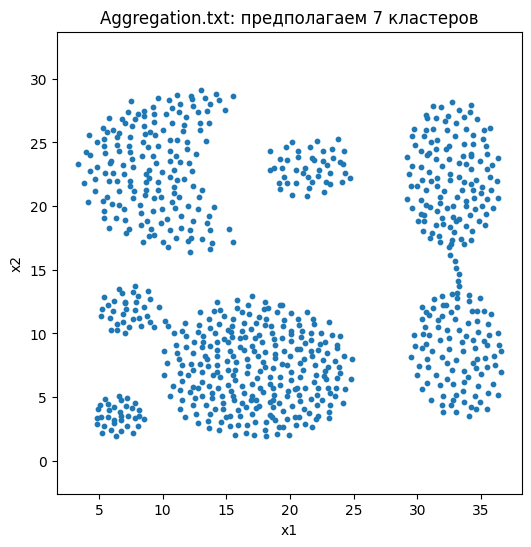

In [27]:
path = "data/Aggregation.txt"
df = pd.read_csv(path, sep=r"\s+", header=None, engine="python")
X = df.iloc[:, :2].to_numpy()

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.title("Aggregation.txt: предполагаем 7 кластеров")
plt.xlabel("x1"); plt.ylabel("x2"); plt.axis("equal")
plt.show()

Раскрасьте данные, используя третий столбец

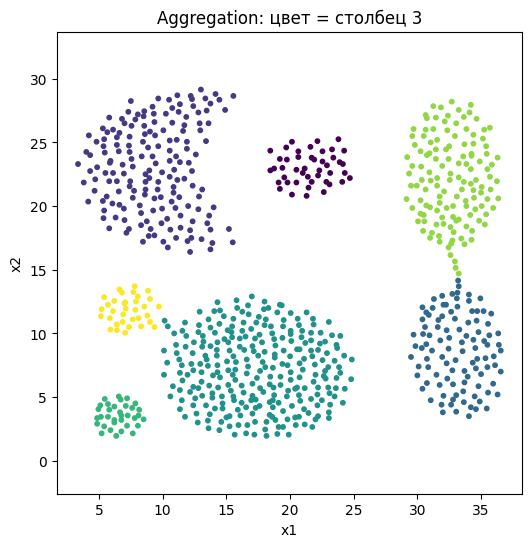

In [29]:
labels = df.iloc[:, 2].to_numpy()

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], s=10, c=labels)  # цвет по третьему столбцу
plt.xlabel("x1"); plt.ylabel("x2"); plt.axis("equal"); plt.title("Aggregation: цвет = столбец 3")
plt.show()

**Вопрос:** совпадает ли это с вашей гипотезой?

Да, но разбиение было очевидным

Примените к этим данным алгоритмы Kmeans и Spectral Clustering. Попробуйте разное количество кластеров $k=3,5,7,10$ Визуализируйте результат работы алгоритмов

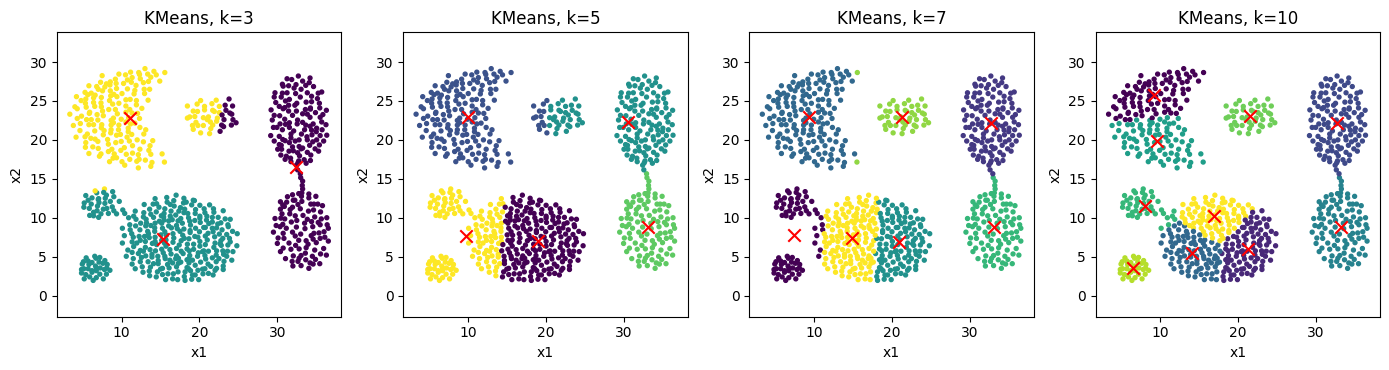

/Users/zuha/miniconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/zuha/miniconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/zuha/miniconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/zuha/miniconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


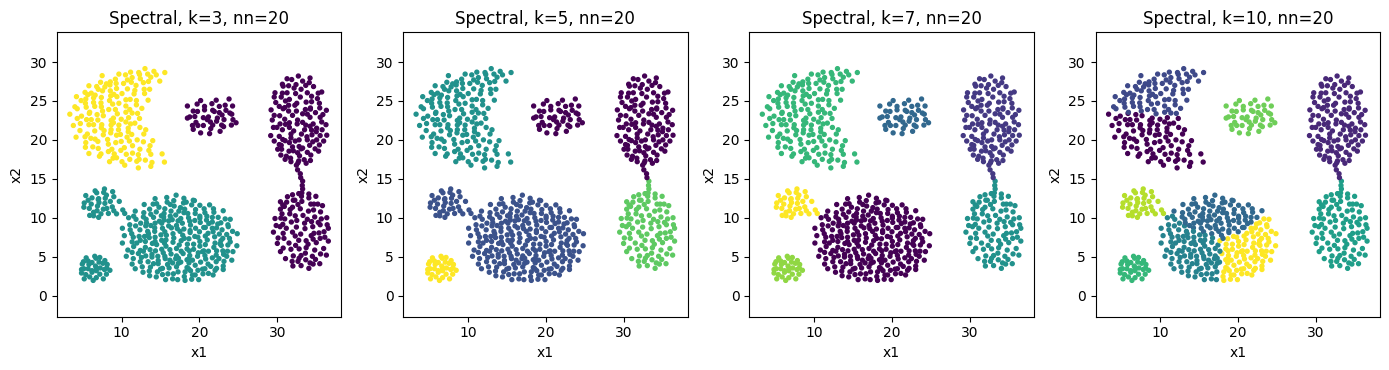

In [39]:
ks = [3, 5, 7, 10]
y_kmeans = {}
y_spec   = {}

# --- KMeans ---
fig, axes = plt.subplots(1, len(ks), figsize=(14, 3.8))
for ax, k in zip(axes, ks):
    km = KMeans(n_clusters=k, n_init=10)
    y_kmeans[k] = km.fit_predict(X)
    ax.scatter(X[:, 0], X[:, 1], s=8, c=y_kmeans[k])
    ax.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], marker="x", s=80, color="red")
    ax.set_title(f"KMeans, k={k}")
    ax.set_xlabel("x1"); ax.set_ylabel("x2"); ax.axis("equal")
plt.tight_layout(); plt.show()

# --- Spectral Clustering ---
# heuristic для числа соседей в графе
n_neighbors = max(8, min(20, int(np.sqrt(len(X)))))
fig, axes = plt.subplots(1, len(ks), figsize=(14, 3.8))
for ax, k in zip(axes, ks):
    sc = SpectralClustering(
        n_clusters=k,
        affinity="nearest_neighbors",
        n_neighbors=n_neighbors,
        assign_labels="kmeans"
    )
    y_spec[k] = sc.fit_predict(X)
    ax.scatter(X[:, 0], X[:, 1], s=8, c=y_spec[k])
    ax.set_title(f"Spectral, k={k}, nn={n_neighbors}")
    ax.set_xlabel("x1"); ax.set_ylabel("x2"); ax.axis("equal")
plt.tight_layout(); plt.show()

Проверьте результат кластеризации с помощью метрики [NMI](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html)

In [41]:
from sklearn.metrics import normalized_mutual_info_score as NMI

y_true = df.iloc[:, 2].to_numpy()

rows = []
for k in ks:
    rows.append({
        "k": k,
        "NMI_KMeans": NMI(y_true, y_kmeans[k], average_method="arithmetic"),
        "NMI_Spectral": NMI(y_true, y_spec[k],   average_method="arithmetic"),
    })

res = pd.DataFrame(rows).sort_values("k")
res[["NMI_KMeans", "NMI_Spectral"]] = res[["NMI_KMeans", "NMI_Spectral"]].round(4)
print(res.to_string(index=False))

 k  NMI_KMeans  NMI_Spectral
 3      0.7440        0.7700
 5      0.8150        0.9116
 7      0.8792        0.9884
10      0.8434        0.8556


**Вопрос:** Предположите, почему данные кластеризовались таким образом? Какой из алгоритмов дал лучший результат?

Лучший результат ожидаемо получился у Spectral Clustering. K-means минимизирует $\sum\limits_{i}\|x_i-\mu_{c(i)}\|^2$ и даёт выпуклые области Вороного с линейными границами. Это сливает близкие компоненты, если центры оказываются по одну сторону узкого “моста”, а также режет изогнутые/длинные кластеры на несколько частей при неподходящем k.
Spectral Clustering строит kNN-граф, считает собственные векторы нормализованного лапласиана L и фактически оптимизирует normalized cut. Межкластерных рёбер мало, внутри много, разрез проходит по “тонким” местам. Поэтому при k=7 почти идеальное соответствие меткам; при k=5 недосегментация, при k=10 лишние разрезы кластеров.

## Задача 2

### DBSCAN, OPTICS

Теперь познакомимся c другим метрическим алгоритмом DBSCAN и его улучшением OPTICS. Эти методы основаны на предположении, что плотность данных внутри кластера больше, чем плотность данных между кластерами. Такое предположение используется алгоритмом для определения оптимального числа кластеров

Создайте три нормальные кучи разной степени разреженности и примените к ним метод [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

In [ ]:
#Your code here

**Вопрос**: Много ли получилось некластеризованных точек (outliers)?

*Your answer here*

Алгоритм DBSCAN имеет два параметра *eps* - радиус поиска, и *min_samples* - необходимое количество точек внутри радиуса поиска. Изменяя эти параметры, попробуйте искать кластеры разной плотности

In [ ]:
#Your code here

**Вопрос**: Как меняется количество outliers в зависимости от этих параметров?

*Your answer here*

Метод OPTICS это модификация DBSCAN, которая предполагает, что кластеры могут иметь разную плотность, а значит и разные радиусы поиска, и пересчитывает их для кластеров

Примените [OPTICS](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html), визуализируйте результаты и сравните с DBSCAN

In [ ]:
#Your code here

**Вопрос:** Сделайте предположение, почему результаты DBSCAN и OPTICS отличаются именно так. Обоснуйте свой ответ

*Your answer here*

Теперь возьмите данные из файла Unbalance.txt. Используя в качестве фичей первые два столбца, визуализируйте данные и сделайте предположение об оптимальном количестве кластеров

In [ ]:
#Your code here

Раскрасьте данные, используя третий столбец

In [ ]:
#Your code here

**Вопрос:** совпадает ли это с вашей гипотезой?

*Your answer here*

Примените к этим данным алгоритмы DBSCAN и OPTICS. Визуализируйте результат работы алгоритма. Поcчитайте метрику NMI

In [ ]:
#Your code here

**Вопрос:** Получилось ли улучшить результаты с помощью метода OPTICS?

*Your answer here*

## Задача 3

В этой задаче вы познакомитесь с иерархической кластеризацией. До этого вы работали с готовыми методами, которые опираются на предположение о возможной структуре данных. Иерархический подход напротив, позволяет в некотором смысле посмотреть на структуру данных и сделать предположение о числе кластеров

### Знакомство с дендрограммой

Иерархический подход заключается в построении дендрограммы на основе матрицы расстояний (linkage): дерево, визуализирующее расстояния между точками и возможными кластерами. Подробнее [здесь](https://www.geeksforgeeks.org/python/scipy-cluster-hierarchy-dendrogram/)

Подключите необходимые методы

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

Считайте данные из файла dim032

In [ ]:
# Your code here

Посчитайте матрицу расстояний linkage и постройте дендрограмму

In [ ]:
# Your code here

**Вопрос:** Сколько кластеров вы можете выделить на дендрограмме? Совпадает ли это с количеством классов в файле dim032-l?



*Your answer here*

Способ подсчёта расстояния в функции linkage можно изменить с помощью параметра *metric*, а за условие объединения кластеров отвечает параметр *method*.

Ознакомьтесь в [документации](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) с возможными значениями параметров *metric* и *method*, постройте несколько дендрограмм с понравившимися вам вариантами

In [ ]:
# Your code here

**Вопрос:** На какой дендрограмме разделение на кластеры наиболее наглядно? Сделайте предположение почему?

*Your answer here*

### Использование Дендрограммы для кластеризации

Как вы убедились выше, дендрограмму можно использовать для предположения о количестве кластеров. Для реализации иерархической кластеризации можно использовать метод [Agglomerative Clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html), который использует дендрограмму для объединения данных в кластеры

Примените метод Agglomerative Clustering с параметрами наилучшей дендрограммы, которую вы получили выше. Посчитайте метрику NMI

In [ ]:
#Your code here

### Метрики

Вообще оценить качество кластеризации мы можем только если проверяем гипотезу о том, что данные разделимы на какие-то известные нам классы. То есть известны истинные метки классов

В этом случае нам интересны две вещи:
1. В одном кластере находятся точки только из одного класса ([Homogeneity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html))
2. Точки одного класса попадают целиком в один кластер ([Completeness](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html))

Данные метрики имеют имеют схожий подход с метриками классификации Precision и Recall соотвественно

Чтобы смотреть на ситуацию в целом, используется среднее гармоническое этих величин, она же [V-measure](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html), что соотвествует F-score, при этом, конечно, можно выбирать, какой из метрик отдается большее предпочтение (параметр *beta*). Дефолтная NMI соотвествует V-meausre с $beta=1$

Теперь посмотрите, как меняются предложенные метрики на методе Agglomerative Clustering при разном количестве кластеров (большем, меньшем и равном количеству классов)

In [ ]:
#Your code here

**Вопрос:** Как меняются метрики в зависимости от количества кластеров? Обоснуйте, почему так происходит

*Your answer here*

Посмотрите, что будет с метриками, если перемешать предсказанные метки

In [ ]:
#Your code here

**Вопрос:** Как изменились метрики? Обоснуйте результат

*Your answer here*

## Задача 4

В файлах bank_genuine.txt и bank_forge.txt приводятся данные о фальшивых и настоящих деньгах. Объедините их в один массив, попробуйте разные алгоритмы кластеризации, найдите тот, что дает наилучший результат

In [ ]:
#Your code here

**Вопрос:** Обоснуйте свой выбор и полученный результат

*Your answer here*